### Figure: Linking atmospheric forcing and ocean interior

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Universal variables
rootdir = 'data/'
yrst = 1958
yrinit = 1976
yrend = 2016
years = np.arange(yrst,yrend+1,1)
years_c = 0.5*(years[:-1]+years[1:])
years_init = np.arange(yrinit,yrend+1,1)
years_init_c = 0.5*(years_init[:-1]+years_init[1:])

In [3]:
# Load NAO data
filepath_nao = rootdir+'raw/nao_pc_djf_0.txt'
nao_vals = np.loadtxt(filepath_nao,skiprows=1)[:,1]
nao_years = np.loadtxt(filepath_nao,skiprows=1)[:,0]
nao = xr.DataArray(nao_vals,dims=['years'],coords={'years':nao_years})
nao = nao.sel(years=slice(yrst,yrend+1))

# Load mixed layer volume from model
# This is the summed volume in the mixed layer north of 45N as defined by the somxl010 variable
# Evaluated in Feb-Mar-Apr of each year
# See calc_Vmld.py for details of calculation
filepath_mld = rootdir+'processed/eulerian/orca025_NA_Vmld.nc'
vmld = xr.open_dataarray(filepath_mld)

# Load volumetric distribution of age from ariane output
filepath_vlag = rootdir+'processed/lagrangian/D2_weights-init_volume_bins-final_age-init_t_subset-final_section-7_alt.nc'
vlag = xr.open_dataarray(filepath_vlag)

In [23]:
# PROCESS DATA

# Eulerian
# Group data by years and take the mean
vmld_byyear = vmld.groupby(vmld.time_counter.dt.year,years).mean(dim='time_counter')
# Calculate annual anomaly
vmld_anom = vmld_byyear-vmld_byyear.mean('year')

# Lagrangian

# Age anomaly
vlag_itmean = vlag.where(vlag!=0).mean('init_t_bin')
vlag_anom = (vlag.isel(init_t_bin=-1)-vlag_itmean)/vlag_itmean
# Rebrand coord as year
vlag_anom = vlag_anom.rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years_c))

# Anomaly in volume of age 1
vlag_age1_mean = vlag.isel(final_age_bin=0).mean('init_t_bin')
vlag_age1_anom = vlag.isel(final_age_bin=0)-vlag_age1_mean
# Rebrand coord as year
vlag_age1_anom = vlag_age1_anom.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c)
# Anomaly in volume of age 2
vlag_age2_mean = vlag.isel(final_age_bin=1).mean('init_t_bin')
vlag_age2_anom = vlag.isel(final_age_bin=1)-vlag_age2_mean
# Rebrand coord as year
vlag_age2_anom = vlag_age2_anom.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c-1)

# %age re-entrainment after 1 year
vlag_inyear = vlag.isel(final_age_bin=0)
vlag_oneyearlater = vlag.shift(init_t_bin=-1).isel(final_age_bin=1)
vlag_twoyearlater = vlag.shift(init_t_bin=-2).isel(final_age_bin=2)
vlag_reent_oneyearlater = 100*(vlag_inyear-vlag_oneyearlater)/vlag_inyear
vlag_reent_twoyearlater = 100*(vlag_oneyearlater-vlag_twoyearlater)/vlag_inyear
vlag_reent_oneyearlater = vlag_reent_oneyearlater.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c)
vlag_reent_twoyearlater = vlag_reent_twoyearlater.rename(
    {'init_t_bin':'init_year_bin'}).assign_coords(
    init_year_bin=years_init_c)

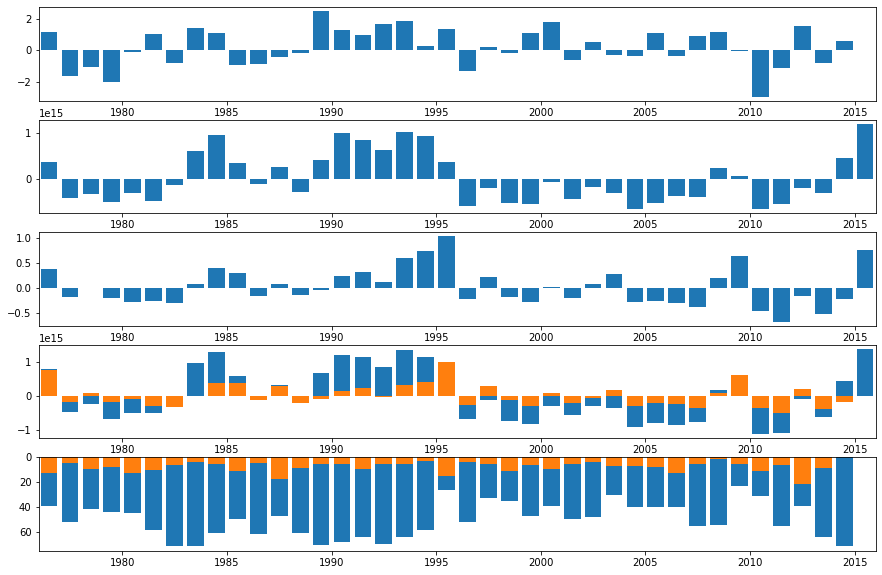

In [28]:
# PLOT
fig,ax = plt.subplots(figsize=(15,10),nrows=5)
xlims = [yrst+18,yrend]
# NAO
ax[0].bar(years_c[:-1],nao)
ax[0].set_xlim(xlims)
# Vmld
ax[1].bar(years_c, vmld_anom)
ax[1].set_xlim(xlims)
# Vlag
ax[2].bar(vlag_anom.final_year_bin,vlag_anom)
ax[2].set_xlim(xlims)
# Anomalies after 1 and 2 years
ax[3].bar(vlag_age1_anom.init_year_bin,vlag_age1_anom)
ax[3].bar(vlag_age2_anom.init_year_bin,vlag_age2_anom)
ax[3].set_xlim(xlims)
# % Re-entrainment in first two years
ax[4].bar(vlag_reent_oneyearlater.init_year_bin,vlag_reent_oneyearlater)
ax[4].bar(vlag_reent_twoyearlater.init_year_bin,vlag_reent_twoyearlater)
ax[4].set_xlim(xlims)
ax[4].invert_yaxis()